In [2]:
import sys, os
EXT_DIR = ['..', '../models/imagenet']
for DIR in EXT_DIR:
    if DIR not in sys.path: sys.path.append(DIR)

import numpy as np
import torch
from torch import nn, tensor
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import PIL.Image as Image
import random
import math
import matplotlib.pyplot as plt
import glob
import cv2
from utils import accuracy, AverageMeter, replace_Conv2d, replace_Linear, replace_BatchNorm2d, Interp1d

device='cuda'
gpu_num = '2' # select GPU if necessary
class_num = 1000 # output class(es) num
target_class = 7 # attack Target : Cock
dataroot = '/pan1/sgx/datasets/ILSVRC' # use your own imagenet directory!!!
physical_attacked_samples_path = '../datasets/physical_attacked_samples'
# Transform
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
imagenet_transform = transforms.Normalize(
    mean=mean,
    std=std
)
reverse_imagenet_transform = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)


data_path = os.path.join(dataroot, 'non_target_samples_20.tensor')
test_non_target_samples = torch.load(data_path).to(device=device)[:10]
test_non_target_samples = reverse_imagenet_transform(test_non_target_samples)
original_image = test_non_target_samples

def apply_Gotham(inputs):
    """
    Pure GPU-version Gotham filter, modified from https://www.practicepython.org/blog/2016/12/20/instagram-filters-python.html
    `inputs`: tensor of size [batch_size, #channel, width, height]
    """
    device = inputs.device
    inputs = inputs.cpu()
    sharpen = transforms.RandomAdjustSharpness(sharpness_factor=2)

    def channel_adjust(channel, values):
        orig_size = channel.shape
        flat_channel = channel.flatten()
        adjusted = Interp1d()(torch.linspace(0, 1, len(values)).to(device=channel.device), torch.tensor(values).to(device=channel.device), flat_channel)
        return adjusted.reshape(orig_size)

    r = inputs[:, 0, :, :]
    b = inputs[:, 2, :, :]
    r_boost_lower = channel_adjust(r, [0, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95, 1.0])
    b_more = torch.clip(b - 0.3, 0, 1.0) # 0.03 -> 0.1
    merged = torch.cat((r_boost_lower.unsqueeze(1), inputs[:, 1, :, :].unsqueeze(1), b_more.unsqueeze(1)), dim=1).to(device=device)
    final = sharpen(merged)
    b = final[:, 2, :, :]
    b_adjusted = channel_adjust(b, [0, 0.047, 0.118, 0.251, 0.318, 0.392, 0.42, 0.439, 0.475, 0.561, 0.58, 0.627, 0.671, 0.733, 0.847, 0.925, 1])
    final[:, 2, :, :] = b_adjusted
    return final.float()

def apply_BlackWhite(inputs):
    """
    `inputs`: tensor of size [batch_size, #channel, width, height]
    """
    device = inputs.device
    inputs = inputs.cpu()

    r = inputs[:, 0, :, :]
    g = inputs[:, 1, :, :]
    b = inputs[:, 2, :, :]
    final = (0.2989 * r + 0.5870 * g + 0.1140 * b).unsqueeze(1).repeat(1, 3, 1, 1).to(device=device)
    print(final.shape)
    return final.float()


torch.Size([10, 3, 224, 224])


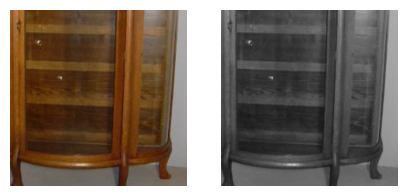

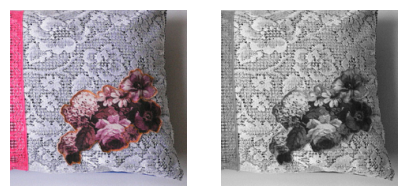

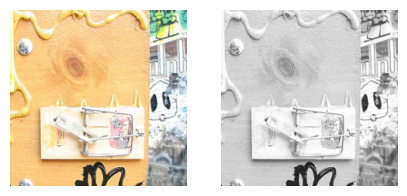

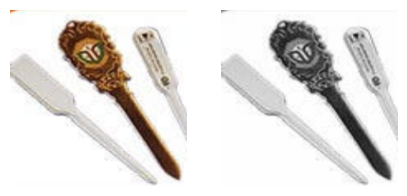

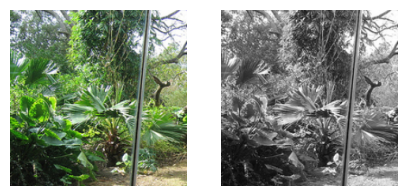

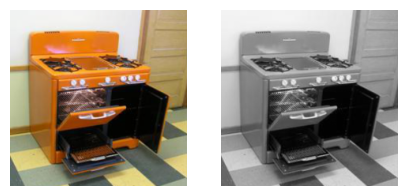

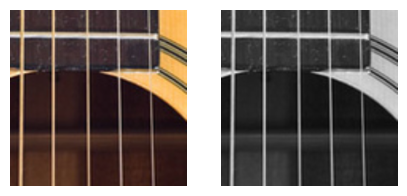

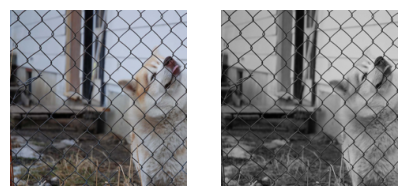

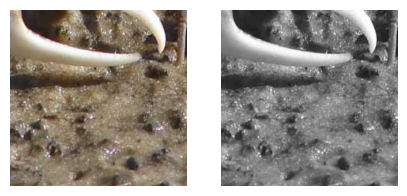

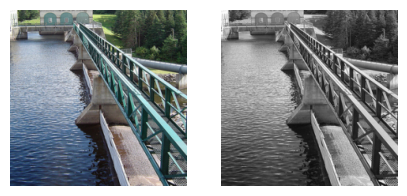

In [3]:
# final = apply_Gotham(original_image)
final = apply_BlackWhite(original_image)
num_img = final.shape[0]
for i in range(num_img):
    plt.figure(figsize=(num_img / 2, 30))
    demo = plt.subplot(num_img, 2, i * 2 + 1)
    demo.imshow(test_non_target_samples[i].cpu().permute(1, 2, 0))
    demo.axis('off')
    demo = plt.subplot(num_img, 2, i * 2 + 2)
    demo.imshow(final[i].cpu().permute(1, 2, 0))
    demo.axis('off')
plt.show()